In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import pandas as pd
from IPython.display import Image
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_curve, precision_recall_fscore_support, confusion_matrix

In [2]:
iris_data_ = datasets.load_iris()
iris_data = pd.DataFrame(iris_data_["data"], columns=iris_data_["feature_names"])
iris_data["Y"] = iris_data_["target"]
iris_data["Type"] = iris_data["Y"].apply(lambda y: iris_data_["target_names"][y])
del iris_data["Y"]

In [3]:
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris_data.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type
60,5.0,2.0,3.5,1.0,versicolor
58,6.6,2.9,4.6,1.3,versicolor
144,6.7,3.3,5.7,2.5,virginica
71,6.1,2.8,4.0,1.3,versicolor
43,5.0,3.5,1.6,0.6,setosa


In [5]:
iris_data["Type"].value_counts(normalize=True)

versicolor    0.333333
virginica     0.333333
setosa        0.333333
Name: Type, dtype: float64

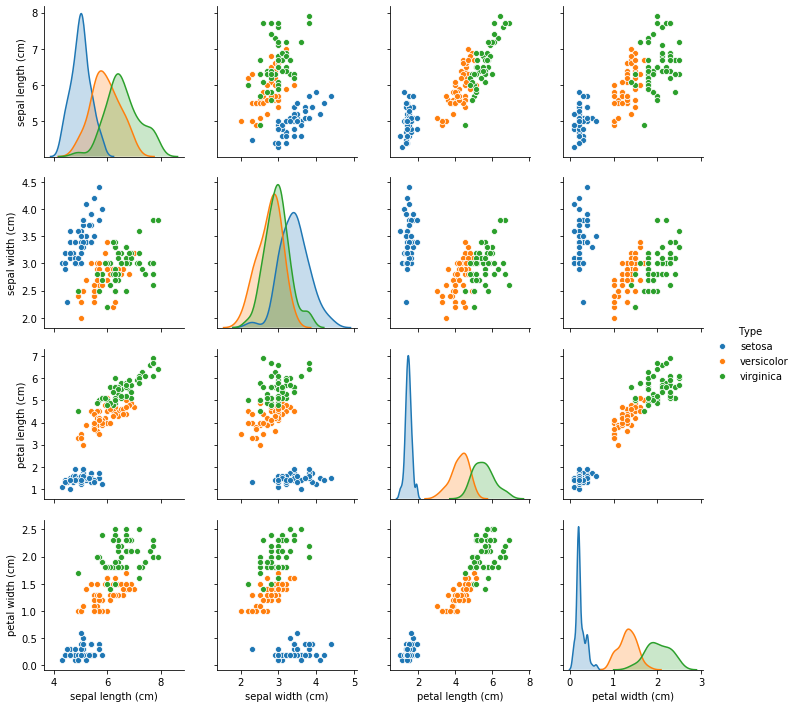

In [6]:
sns.pairplot(iris_data, "Type")

In [7]:
iris_sub = iris_data[iris_data["Type"]!="virginica"].reset_index(drop=True)

In [8]:
iris_sub2 = iris_data[iris_data["Type"]!="setosa"].reset_index(drop=True)
iris_sub2["Y"] = iris_sub2["Type"].apply(lambda label: 1 if label == "versicolor" else 0)

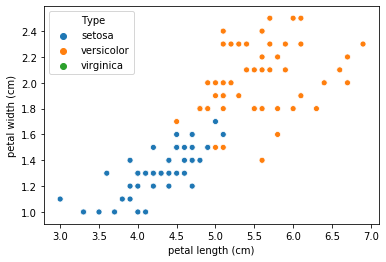

In [9]:
sns.scatterplot(iris_sub2.iloc[:, 2], iris_sub2.iloc[:, 3], hue=iris_data["Type"])

In [10]:
logistic = LogisticRegression(solver="lbfgs")
logistic.fit(iris_sub2.iloc[:, 2:4], iris_sub2["Y"])
print(np.round(logistic.intercept_,2)[0], np.round(logistic.coef_,2)[0])

17.55 [-2.78 -2.39]


w1x1 + w2x2 + w0 = 0
x2 = -w0/w2 - w1/w2 x1

x2 = 17.55/2.39 + 17.55/2.78x1



In [11]:
1/(1 + np.exp(-(np.matmul(iris_sub2.iloc[0, 2:4].values, logistic.coef_[0]) + logistic.intercept_[0])))

TypeError: ufunc 'matmul' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [12]:
y_prob_logistic = logistic.predict_proba(iris_sub2.iloc[:, 2:4])

In [13]:
y_prob_logistic[0]

array([0.23985297, 0.76014703])

In [14]:
confusion_matrix(iris_sub2["Y"],np.where(y_prob_logistic[:, 1]>=0.5, 1, 0))

array([[48,  2],
       [ 3, 47]], dtype=int64)

In [15]:
confusion_matrix(iris_sub2["Y"],np.where(y_prob_logistic[:, 1]>=0.53, 1, 0))

array([[49,  1],
       [ 3, 47]], dtype=int64)

In [16]:
f1_score(iris_sub2["Y"],np.where(y_prob_logistic[:, 1]>=0.50, 1, 0))

0.9494949494949495

In [17]:
f1_score(iris_sub2["Y"],np.where(y_prob_logistic[:, 1]>=0.53, 1, 0))

0.9591836734693877

In [18]:
roc_auc_score(iris_sub2["Y"], y_prob_logistic[:, 1])

0.9912

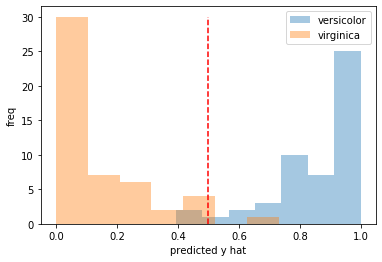

In [19]:
sns.distplot(y_prob_logistic[:, 1][np.where(iris_sub2["Type"]=="versicolor")], kde=False)
sns.distplot(y_prob_logistic[:, 1][np.where(iris_sub2["Type"]!="versicolor")], kde=False)
plt.legend(["versicolor", "virginica"])
plt.xlabel("predicted y hat")
plt.ylabel("freq")
plt.vlines(0.5,0,30,"r", "dashed")

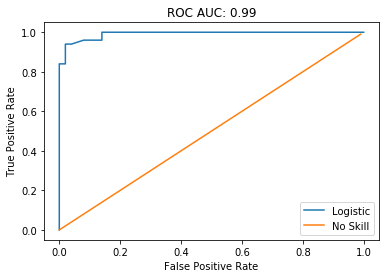

In [20]:
fpr, tpr, th = roc_curve(iris_sub2["Y"], y_prob_logistic[:, 1])

roc_auc = roc_auc_score(iris_sub2["Y"], y_prob_logistic[:, 1])

plt.plot(fpr, tpr)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Logistic", "No Skill"])
plt.title("ROC AUC: {:.2f}".format(roc_auc));

In [21]:
f1_scores = []
for th_ in np.arange(0, 1, 0.01):
    f1_scores.append(f1_score(iris_sub2["Y"],np.where(y_prob_logistic[:, 1]>=th_, 1, 0)))

max_f1_th = np.arange(0, 1, 0.01)[np.argmax(f1_scores)]
max_f1 = np.max(f1_scores)

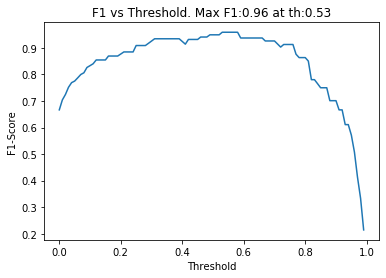

In [22]:
plt.plot(np.arange(0, 1, 0.01),f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1 vs Threshold. Max F1:{:.2f} at th:{}".format(max_f1, max_f1_th));

## SVM

In [23]:
iris_sub.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [24]:
iris_sub["Type"].value_counts()

versicolor    50
setosa        50
Name: Type, dtype: int64

In [25]:
iris_sub["Y"] = iris_sub["Type"].apply(lambda cat: 0 if cat=="setosa" else 1)

In [26]:
iris_sub.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type,Y
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


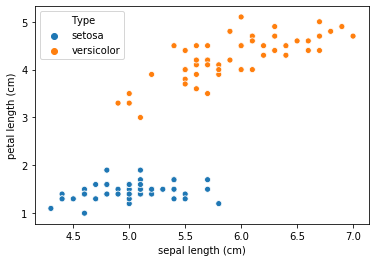

In [27]:
sns.scatterplot(iris_sub.iloc[:, 0],
                iris_sub.iloc[:, 2], 
                hue=iris_sub["Type"]);

In [28]:
perceptron = Perceptron()
perceptron.fit(iris_sub.iloc[:, :2], iris_sub["Y"])
perceptron.coef_ , perceptron.intercept_

C:\Users\dilee\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


(array([[ 19.1, -32.8]]), array([-4.]))

In [29]:
perceptron2 = Perceptron(random_state=73)
perceptron2.fit(iris_sub.iloc[:, [0, 2]], iris_sub["Y"])
perceptron2.coef_ , perceptron2.intercept_

C:\Users\dilee\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


(array([[-5.8, 11.8]]), array([-2.]))

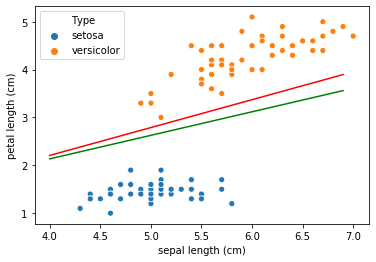

In [30]:
x1 = np.arange(4, 7, 0.1)
x2 = -1 * (perceptron.intercept_[0] + perceptron.coef_[0][0]*x1)/perceptron.coef_[0][1]
x3 = -1 * (perceptron2.intercept_[0] + perceptron2.coef_[0][0]*x1)/perceptron2.coef_[0][1]
sns.scatterplot(iris_sub.iloc[:, 0],
                iris_sub.iloc[:, 2], 
                hue=iris_sub["Type"]);
plt.plot(x1, x2, color="red")
plt.plot(x1, x3, color="green")

In [31]:
svc = SVC(kernel="linear")
svc.fit(iris_sub.iloc[:, [0, 2]], iris_sub["Y"])
svc.intercept_, svc.coef_

(array([-3.82320029]), array([[0.02335031, 1.42690438]]))

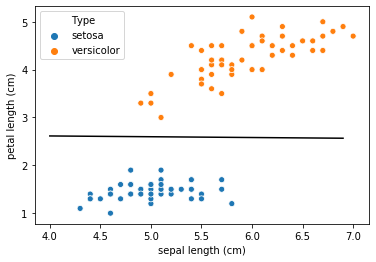

In [32]:
x1 = np.arange(4, 7, 0.1)
x4 = -1 * (svc.intercept_[0] + svc.coef_[0][0]*x1)/svc.coef_[0][1]

sns.scatterplot(iris_sub.iloc[:, 0],
                iris_sub.iloc[:, 2], 
                hue=iris_sub["Type"]);

plt.plot(x1, x4, color="black");

## RBF Kernel

In [33]:
iris_sub2.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type,Y
0,7.0,3.2,4.7,1.4,versicolor,1
1,6.4,3.2,4.5,1.5,versicolor,1
2,6.9,3.1,4.9,1.5,versicolor,1
3,5.5,2.3,4.0,1.3,versicolor,1
4,6.5,2.8,4.6,1.5,versicolor,1


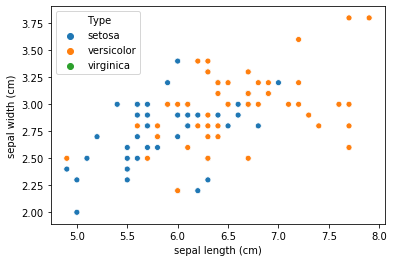

In [34]:
sns.scatterplot(iris_sub2.iloc[:, 0],
                iris_sub2.iloc[:, 1], 
                hue=iris_data["Type"]);

In [35]:
svm_lin = SVC(kernel="linear")
svm_lin.fit(iris_sub2.iloc[:, 0:2], iris_sub2["Y"])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [36]:
def plot_decision_boundary(X, clf, col):
    h = .02 
    x_min, x_max = X[:, 0].min() - 0.05, X[:, 0].max() + 0.05
    y_min, y_max = X[:, 1].min() - 0.05, X[:, 1].max() + 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors=col, linewidths=0.3)

In [37]:
svm_rbf = SVC(kernel="rbf", gamma=100)
svm_rbf.fit(iris_sub2.iloc[:, 0:2], iris_sub2["Y"])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

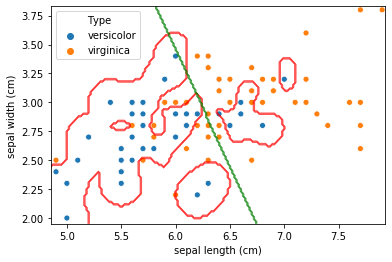

In [38]:
sns.scatterplot(iris_sub2.iloc[:, 0],
                iris_sub2.iloc[:, 1], 
                hue=iris_sub2["Type"]);
plot_decision_boundary(iris_sub2.iloc[:,:2].values, svm_rbf, "red")
plot_decision_boundary(iris_sub2.iloc[:,:2].values, svm_lin, "green")


# Decision Trees

In [39]:
import pydotplus

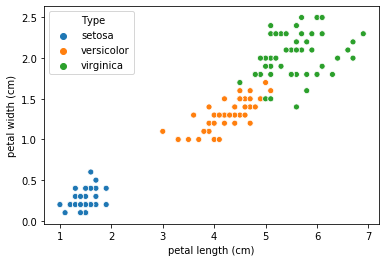

In [40]:
sns.scatterplot(iris_data.iloc[:, 2],
                iris_data.iloc[:, 3], 
                hue=iris_data["Type"]);

In [41]:
clf_dt = DecisionTreeClassifier(max_depth=3, criterion="entropy")
clf_dt.fit(iris_data.iloc[:, 2:4], iris_data["Type"])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

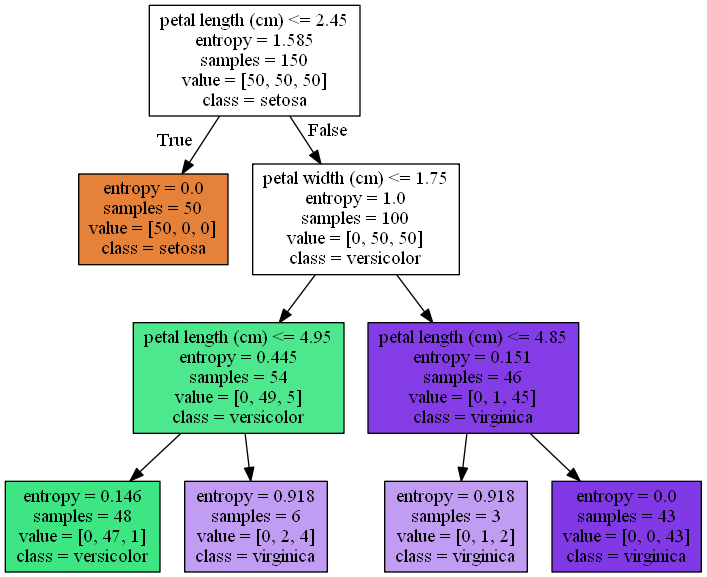

In [42]:
dot_data = export_graphviz(clf_dt, feature_names = iris_data.columns[2:4],
                           class_names = ["setosa","versicolor", "virginica"], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [43]:
def get_entropy(seq):
    p = seq/sum(seq)
    e = 0
    for p_ in p:
        if p_==0:
            continue
        e+= p_ * np.log2(p_)
    return -e

In [44]:
get_entropy(np.array([50, 50, 50]))

1.584962500721156

In [45]:
def plot_decision_boundary_dt(X, clf, col, mapping):
    h = .02 
    x_min, x_max = X[:, 0].min() - 0.05, X[:, 0].max() + 0.05
    y_min, y_max = X[:, 1].min() - 0.05, X[:, 1].max() + 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array([mapping[k] for k in Z])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors=col, linewidths=0.3)

In [46]:
mapping = {"setosa":0, "versicolor":1, "virginica":3}

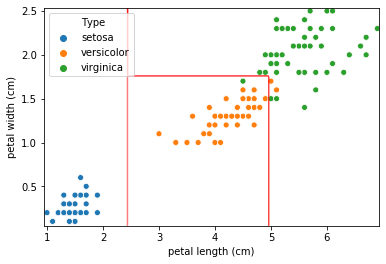

In [47]:
sns.scatterplot(iris_data.iloc[:, 2],
                iris_data.iloc[:, 3], 
                hue=iris_data["Type"]);
plot_decision_boundary_dt(iris_data.iloc[:,2:4].values, clf_dt, "red", mapping)


# Random Forest

In [48]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(iris_data.iloc[:, 2:4], iris_data["Type"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Text(0.5, 1.0, 'Random Forest')

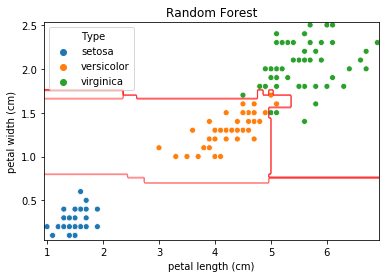

In [49]:
sns.scatterplot(iris_data.iloc[:, 2],
                iris_data.iloc[:, 3], 
                hue=iris_data["Type"]);
plot_decision_boundary_dt(iris_data.iloc[:,2:4].values, rf, "red", mapping)
plt.title("Random Forest")